# Résultats des analyses sur Annonceur1_campagne3_visite_2pages

Nous présentons ici les résultats graphiques et leur analyse pour la campagne mentionnée.

In [1]:
import pandas as pd
from premiere_analyse import *
from testZ import *
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import seaborn as sns
sns.set_style("white")

import numpy as np
import scipy.stats as st
%load_ext autoreload
%autoreload 2

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#données de la campagne
# folder = 'C:/Users/Admin/Documents/Centrale Paris/3A/OMA/Projet/Donnees/'
folder = 'Data/'
annonceur = 'annonceur1/annonceur1'
campagne = 'annonceur1_campaign3_visite_2pages'
data = pd.read_hdf(folder + annonceur + '.hdf', key=campagne)

Analyse du taux de conversion des versions A et B de la bannière en tant que série temporelle

In [ ]:
#préparation des données
dataA, dataB = preparer(data) 

La moyenne du taux de conversion global pour les 2 groupes est très similaire :

In [3]:
data.groupby('group')['is_conv'].mean()

group
A    0.000096
B    0.000093
Name: is_conv, dtype: float64

# Visualisation des données brutes

Est-ce qu'il y a un pattern (journalier, hebdomadaire, mensuel, ...) dans le taux de conversion ou la différence relative de taux de conversion ? 

On ajoutera aussi le nombre total de conversions pour la fréquence donnée afin de savoir si une importante différence relative est significative ou pas (si c'est 100% mais pour un 1 vs 2 par exemple).

In [4]:
freq_list = ["1D", "1W"]

conv_rate = {}
pct_change = {}
conv_count = {}

for freq in freq_list:
    conv_count[freq] = conversion_count_resample(data, freq)
    conv_rate[freq] = conversion_rate_resample(data, freq)
    pct_change[freq] = (conv_rate[freq]["A"] - conv_rate[freq]["B"]) / conv_rate[freq]["B"]
    # attention il y a des NaN quand il y a pas de conversion du groupe B

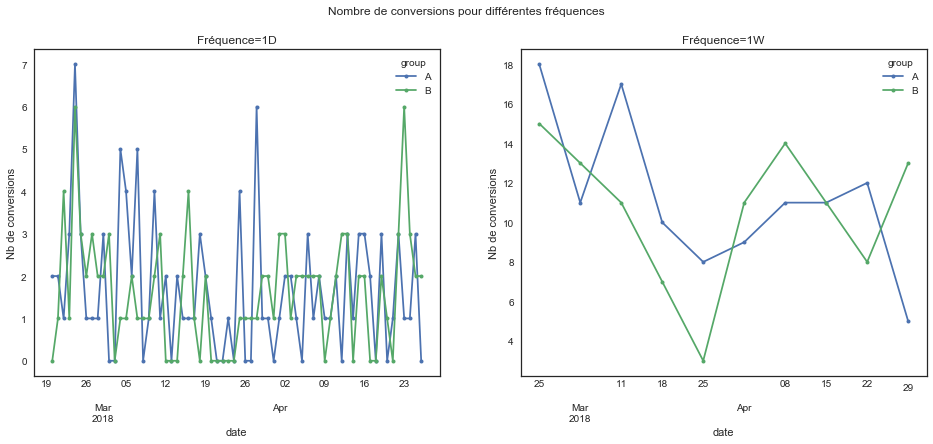

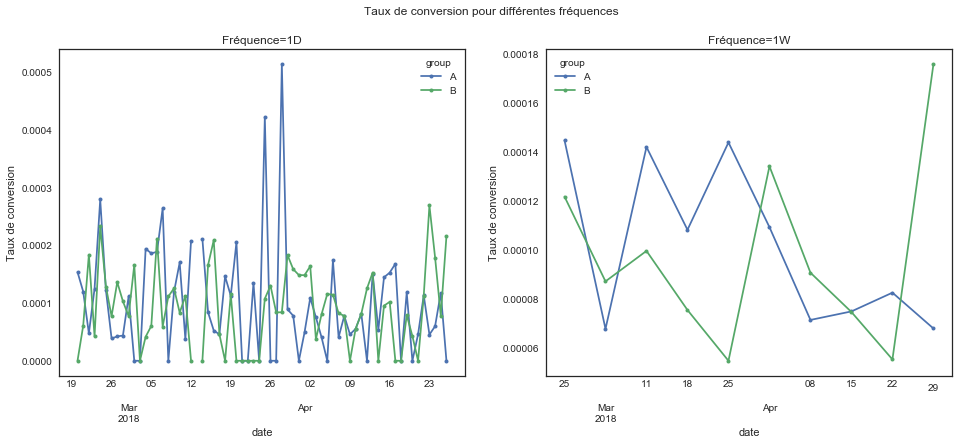

In [5]:
# trace des taux de conversion pour frequences differentes
plt.figure(figsize=(16, 6))
for i, freq in enumerate(freq_list):
    plt.subplot(1, len(freq_list), i+1)
    conv_count[freq].plot(ax=plt.gca(), marker="o", ms=4)
    plt.title(f"Fréquence={freq}")
    plt.ylabel('Nb de conversions')
plt.suptitle('Nombre de conversions pour différentes fréquences')
plt.show()

# trace des taux de conversion pour frequences differentes
plt.figure(figsize=(16, 6))
for i, freq in enumerate(freq_list):
    plt.subplot(1, len(freq_list), i+1)
    conv_rate[freq].plot(ax=plt.gca(), marker="o", ms=4)
    plt.title(f"Fréquence={freq}")
    plt.ylabel('Taux de conversion')
plt.suptitle('Taux de conversion pour différentes fréquences')
plt.show()

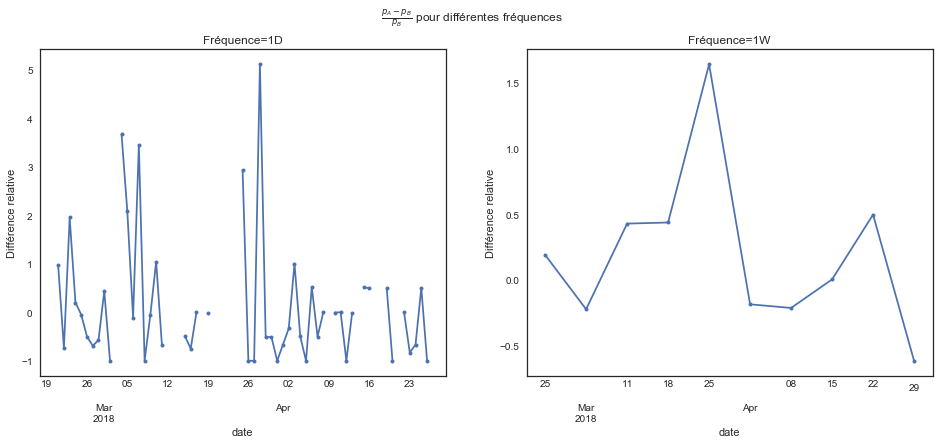

In [6]:
# trace des variations relatives pour frequences differentes
plt.figure(figsize=(16, 6))
for i, freq in enumerate(freq_list):
    plt.subplot(1, len(freq_list), i+1)
    pct_change[freq].plot(ax=plt.gca(), marker="o", ms=4)
    plt.title(f"Fréquence={freq}")
    plt.ylabel('Différence relative')
plt.suptitle('$\\frac{p_A - p_B}{p_B}$ pour différentes fréquences')
plt.show()

Dans l'ensemble il n'y a pas de tendance marquante permettant de distinguer le groupe A du groupe B quel que soit l'échelle considérée pour ce dataset. La différence relative est difficilement exploitable car les taux de conversion peuvent valoir 0 pour les deux groupes.

En revanche, le changement de fréquence permet un lissage des données avec moins de variance mais le nombre de données devient très faible. Peut-être considérer un lissage sur une période glissante de 3 à 5 jours ?

# Test Z

## Test Z global

Enfin, on conduit un Z-test destiné à mesurer l'efficacité statistique du test A/B mené. Mathématiquement, cela se traduit par la comparaison de l'hypothèse nulle H0 : "le taux de conversion sous version A est le même que celui sous version B" avec l'hypothèse H1 : "le taux de conversion sous version A est différent que celui sous version B". 

Pour ce faire, on utilise l'**ensemble des données** (du début jusqu'à la fin de la campagne) du dataset pour réaliser le test qui nous donnera une statistique qui nous permettra de calculer la p-valeur i.e. la probabilité de rejeter l'hypothèse nulle H0, à l'issue de toute la durée de la campagne.

In [8]:
Z, Prej = testZ(data)
print('Zstat = {0:.3}, Pval={1:.3}'.format(Z, Prej))

Zstat = 0.254, Pval=0.8


La Pval étant de 0.8, on ne peut donc pas rejeter l'hypothèse nulle avec un seuil de confiance classique (5%, 1%).

Conclusion : à l'issue toute la campagne, aucune des deux versions n'est meilleure que l'autre en termes de taux de conversion journalier.

## Test Z cumulé

Est-ce que le Z-test aurait donné des résultats différents si l'on a arrêté le test A/B à des instants plus tôt ? 

On s'intéresse maintenant aux **données cumulées** : en regardant l'ensemble des informations dont on dispose du jour 1 de la campagne publicitaire au jour n, peut-on voir une certaine tendance quant au test d'hypothèses ? Est-ce que si l'on avait arrêté le test plus tôt les résultats auraient été différents ?

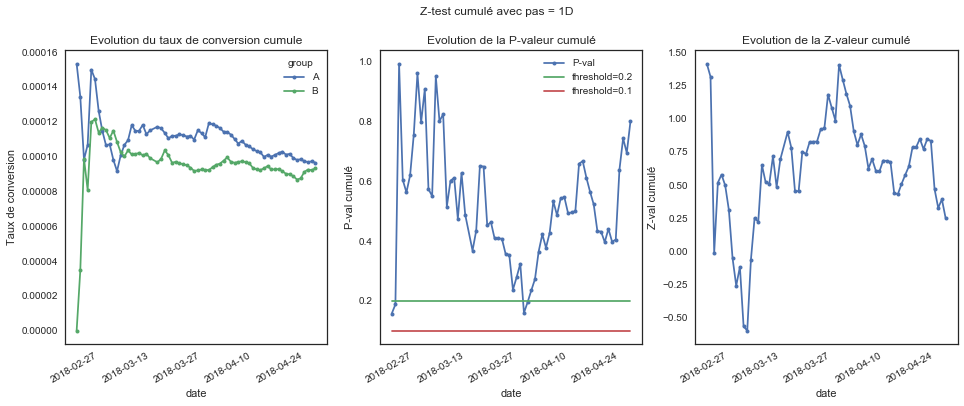

In [11]:
freq = "1D"
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq=freq)
plot_testZ_cum_frequency(Z_cum, P_rej, p_cum, freq)

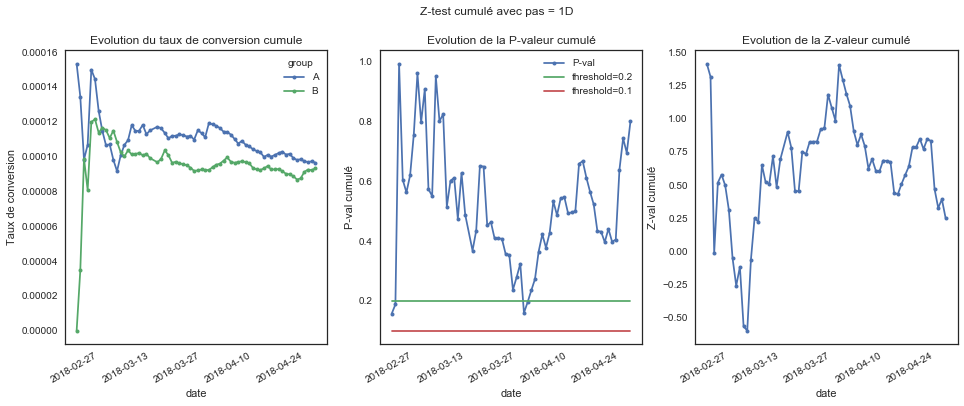

In [10]:
freq = "1D"
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq=freq)
plot_testZ_cum_frequency(Z_cum, P_rej, p_cum, freq)

Les résultats du Z test sont  différents en fonction de l'instant considéré : si on s'était arrêté vers fin Mars on aurait pu rejeter H0 avec un taux de confiance de 20% et dire que A est meilleur. Mais, dans tous les cas, on est au-dessus de la p-valeur de 10% et quasiment tout le temps au-dessus de 20% :  il n'y a pas de variation de la significativité du test et on ne peut pas conclure pour ces niveaux de confiance que les deux versions sont différentes.

Est-ce que la réalisation du testZ cumulé avec un pas de plusieurs jours donnerait de meilleurs résultats ? On fait un test Z avec les données de t0 à t0 + pas, puis t0 à t0 + 2pas...

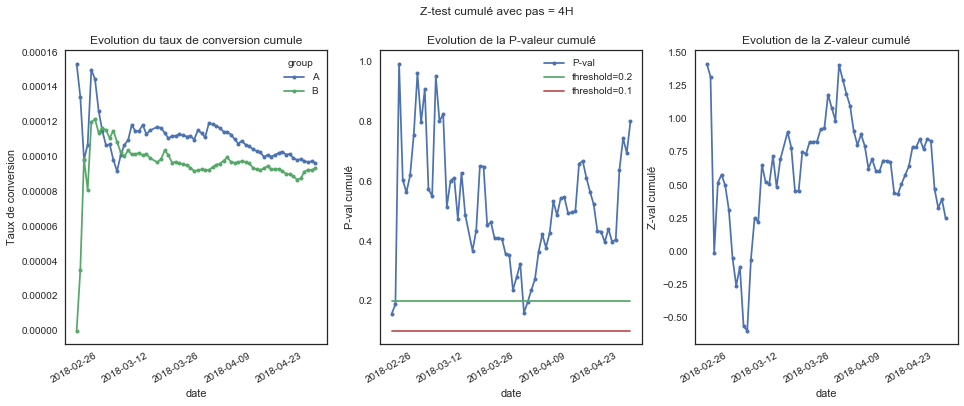

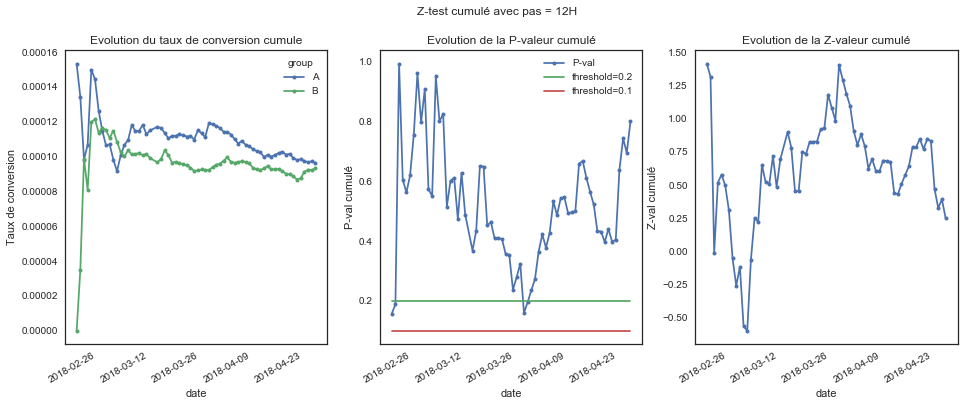

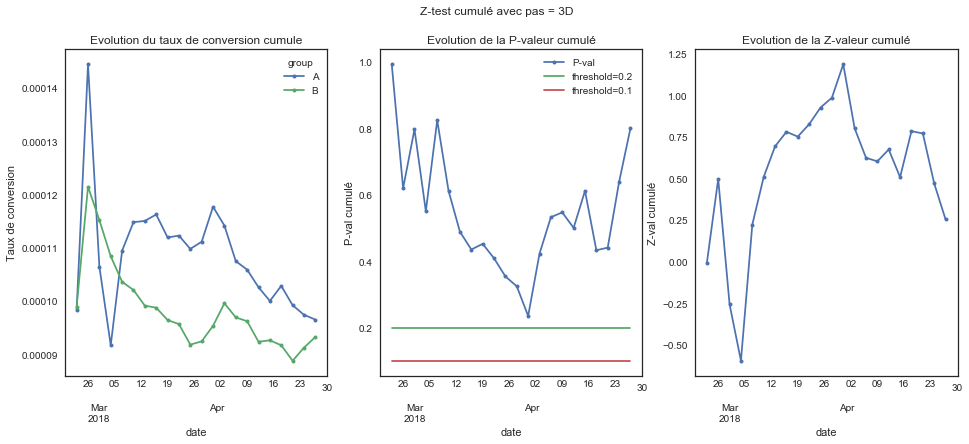

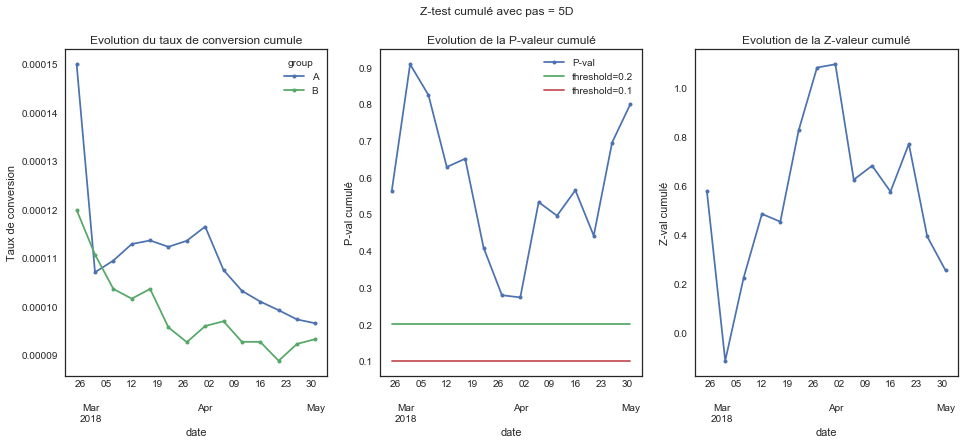

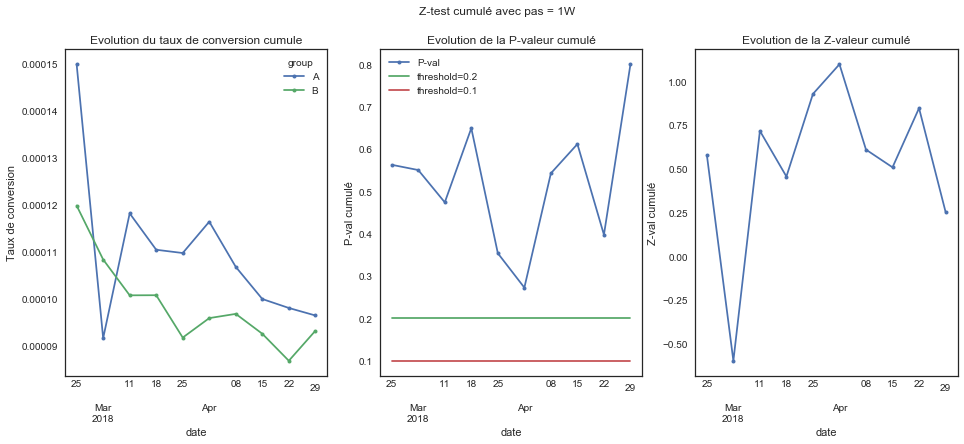

In [34]:
for freq in ["4H", "12H", "3D", "5D", "1W"]:
    Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq=freq)
    plot_testZ_cum_frequency(Z_cum, P_rej, p_cum, freq)

Conclusion : 

Avec des pas de 4H, 12H, 3, 5 et 7 jours, la conclusion reste la même, aucune version n'est meilleure.

Il serait peut-être intéressant d'étudier la stationnarité de la série des Pval ou de la valeur Z.  